In [1]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from TransferEntropy.transfer_entropy import get_transfer_entropy
from constants import ATR_ABNORMALITY_COLUMN
from tqdm import tqdm
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (70,30)

coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT"]
feature = "close"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"
transfer_entropy_lookback = 2
suptitle_fontsize = 40
font_scale = 3
candle_size = "1d"
num_samples = 1440 # 60*24

In [2]:
data_manager = DataManager()
        # self.transfer_entropy = TransferEntropy(lookback=transfer_entropy_lookback, window_size=num_samples)

main_1d_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1d").df
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]
# main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnormal_timestamp_list = main_1d_df[main_1d_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [3]:
def add_HLOC(input_df):
    input_df["HLOC"] = input_df[["high", "low", "open", "close"]].mean(axis=1)

def join_dataframes(coin_data_list):
    df = pd.DataFrame(index=coin_data_list[0].df.index)

    for coin_data in coin_data_list:
        add_HLOC(coin_data.df)
        df = df.join(coin_data.df[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")
    
    df.rename(columns={feature:f"{feature}_{coin_data_list[0].coin_symbol}"}, inplace=True)    
    df.dropna(how="any", inplace=True)
    df.drop(columns=["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

In [4]:
feature = "HLOC"
raw_df = join_dataframes(coin_data_list=coin_data_list)

In [5]:
raw_df

,HLOC_BTCUSDT,HLOC_ETHUSDT,HLOC_ADAUSDT,HLOC_LTCUSDT
timestamp,,,,
2018-04-17 04:02:00,8032.2675,507.4825,0.262755,130.3775
2018-04-17 04:03:00,8029.5825,507.7750,0.265520,130.3475
2018-04-17 04:04:00,8031.9825,507.5625,0.264090,130.2375
2018-04-17 04:05:00,8030.2575,507.5750,0.266665,130.2000
2018-04-17 04:06:00,8030.3975,507.4225,0.268657,130.1900
...,...,...,...,...
2021-06-30 10:39:00,34821.2175,2136.3725,1.337850,140.7850
2021-06-30 10:40:00,34806.3500,2135.0400,1.337325,140.6150
2021-06-30 10:41:00,34757.6175,2132.1900,1.336250,140.3800


In [6]:
df = raw_df["2021-01-01":].resample("5min").median()

In [7]:
df

,HLOC_BTCUSDT,HLOC_ETHUSDT,HLOC_ADAUSDT,HLOC_LTCUSDT
timestamp,,,,
2021-01-01 00:00:00,28986.13750,737.6625,0.181258,124.5900
2021-01-01 00:05:00,28940.80000,735.4750,0.179665,124.3875
2021-01-01 00:10:00,28829.51000,732.0400,0.178890,123.7425
2021-01-01 00:15:00,28803.09500,731.5675,0.179448,123.5100
2021-01-01 00:20:00,28793.70500,730.5625,0.179317,123.3000
...,...,...,...,...
2021-06-30 10:20:00,34722.37000,2126.3250,1.335675,140.4550
2021-06-30 10:25:00,34776.81000,2129.1125,1.339300,140.5575
2021-06-30 10:30:00,34783.54750,2132.6275,1.337825,140.7450


In [8]:
df.describe()

,HLOC_BTCUSDT,HLOC_ETHUSDT,HLOC_ADAUSDT,HLOC_LTCUSDT
count,51850.000000,51850.000000,51850.000000,51850.000000
mean,45841.084360,2062.482490,1.120021,198.901825
std,10020.691226,703.914206,0.478690,57.695609
min,28687.990000,717.980000,0.169272,105.937500
25%,36183.118750,1605.665625,0.890077,157.636250
50%,47139.935000,1915.277500,1.206654,184.165000
75%,55841.257500,2453.553750,1.423385,225.211250
max,64645.542500,4359.330000,2.453850,411.047500


In [9]:
data_manager.add_noise_to_df(df, mu = 0, sigma = 10)
df.dropna(how="any", inplace=True)

In [16]:
from TransferEntropy.transfer_entropy import EEC
num_cols = len(df.columns)
n = len(df)
L = 3
result = np.ones(shape=(num_cols, num_cols))
for i, coli in tqdm(enumerate(df.columns)):
    for j, colj in enumerate(df.columns): 
        list_i, list_j = [], []
        arr_i = df[coli].to_numpy()
        arr_j = df[colj].to_numpy()
        print(arr_i, arr_j)
        # create windows.
        for l in range(L+1):
            list_i.append(arr_i[l:n-L+l])
            list_j.append(arr_j[l:n-L+l])
        
        joint_entropy = EEC(np.array([arr_i, arr_j]).T)
        entropy_value = get_transfer_entropy(np.array(list_i), np.array(list_j))
        result[i, j] = entropy_value

3it [04:20, 86.95s/it]

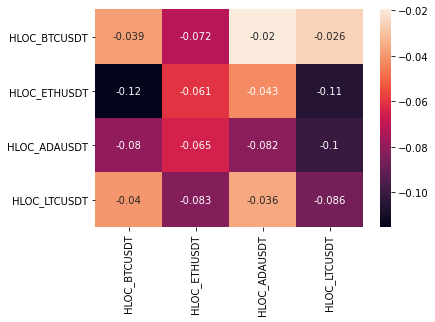

In [ ]:
result = pd.DataFrame(data=result, columns=df.columns, index=df.columns)
sn.heatmap(result, annot=True);